# OpenVino Implementation using Openvino Runtime

In [913]:
# initialize minimum probability to filter weak detections along with
MIN_CONF = 0.5

# define the minimum safe distance (in pixels) that two people can be
# from each other
MIN_DISTANCE = 700

In [914]:
import cv2
import numpy as np
from PIL import Image

In [915]:
def plot_boxes(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], boxes =None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and boxes is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    bboxes= boxes or results[:, 0:4]
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for idx, box in enumerate(bboxes):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)

In [916]:
def calc_centroids(results:np.ndarray):
    bboxes= results[:, 0:4]
    centroids = []
    for box in bboxes:
        #box = xyxy[0:4]
        c = int((box[0] + box[2])/2), int((box[1] + box[3])/2)
        centroids.append(c)
    return centroids

In [917]:
def plot_centroids(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], centroids:list[tuple[int, int]] = None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    centroids = centroids or calc_centroids(results)
    for idx, centroid in enumerate(centroids):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        cv2.circle(img =img, center =centroid,radius=5, color=color, thickness=tl)

In [918]:
def show_violations(img:np.ndarray, instances:list[int], results:np.ndarray = None, centroids:list[tuple[int, int]]= None, line_thickness:int = None, color = [0, 255, 0]):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    elif centroids is None:
        centroids = calc_centroids(results)

    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for violation in instances:
        color = [255, 0, 0]
        i, j = violation
        cv2.line(img, centroids[i], centroids[j], color, tl)
    
    # draw the total number of social distancing violations on the output frame
    text = "Social Distancing Violations: {}".format(len(instances))
    cv2.putText(img, text, (10, img.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 1.85, color, tl)

In [919]:
from scipy.spatial import distance as dist
def check_violations (results:dict, source_image:np.ndarray):
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = calc_centroids(results)
		D = dist.cdist(centroids, centroids, metric="euclidean")

		violators = set()
		violations = set()
		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violators.add(i)
					violators.add(j)
					violations.add((i, j))
					print(f"violation: {D[i, j]}")
		
	# return the set of violations
	return violators, violations
		

In [920]:
def draw_results(results:dict, source_image:np.ndarray):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image (np.ndarray): for drawing predictions of the format [x1, y1, x2, y2]
        source_image (np.ndarray): input image for drawing bounding boxes and centroids
    Returns:    
    """
    # boxes = results.boxes.data.cpu()
    # centroids = calc_centroids(results)
    # print(centroids)

    violators, violations = check_violations(results, source_image)
    
    # Plot the bounding boxes of the people detected
    plot_boxes(source_image, results, defaulters=violators)#, boxes=boxes)

    # Plot the centroids of the people detected
    plot_centroids(source_image, results, defaulters=violators)#, centroids=centroids)

    # Plot lines between centroids of people violating social distancing
    show_violations(source_image, instances= violations, results=results)#, centroids=centroids)
    

### Preprocessing

Model input is a tensor with the `[-1, 3, -1, -1]` shape in the `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

The model expects images in RGB channels format and normalized in [0, 1] range. Although the model supports dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes, for example, 640x640 for better efficiency. To resize images to fit model size `letterbox`, resize approach is used, where the aspect ratio of width and height is preserved.

To keep a specific shape, preprocessing automatically enables padding.

In [921]:
from typing import Tuple
import torch
import numpy as np


def letterbox(img: np.ndarray, new_shape:Tuple[int, int] = (640, 640), color:Tuple[int, int, int] = (114, 114, 114), auto:bool = False, scale_fill:bool = False, scaleup:bool = False, stride:int = 32):
    """
    Resize image and padding for detection. Takes image as input,
    resizes image to fit into new shape with saving original aspect ratio and pads it to meet stride-multiple constraints

    Parameters:
      img (np.ndarray): image for preprocessing
      new_shape (Tuple(int, int)): image size after preprocessing in format [height, width]
      color (Tuple(int, int, int)): color for filling padded area
      auto (bool): use dynamic input size, only padding for stride constrins applied
      scale_fill (bool): scale image to fill new_shape
      scaleup (bool): allow scale image if it is lower then desired input size, can affect model accuracy
      stride (int): input padding stride
    Returns:
      img (np.ndarray): image after preprocessing
      ratio (Tuple(float, float)): hight and width scaling ratio
      padding_size (Tuple(int, int)): height and width padding size


    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scale_fill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
    """
    # resize
    img = letterbox(img0)[0]

    # Convert HWC to CHW
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def image_to_tensor(image:np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize and changes data layout from HWC to CHW.

    Parameters:
      img (np.ndarray): image for preprocessing
    Returns:
      input_tensor (np.ndarray): input tensor in NCHW format with float32 values in [0, 1] range
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    # add batch dimension
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing

The model output contains detection boxes candidates, it is a tensor with the `[-1,84,-1]` shape in the `B,84,N` format, where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has the [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of the box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting the final prediction, we need to apply a non-maximum suppression algorithm and rescale box coordinates to the original image size.

The instance segmentation model, additionally, has an output that contains proto mask candidates for instance segmentation. It should be decoded by using box coordinates. It is a tensor with the `[-1 32, -1, -1]` shape in the `B,C H,W` format, where:
- `B` - batch size
- `C` - number of candidates
- `H` - mask height
- `W` - mask width

In [922]:
from ultralytics.yolo.utils import ops
def postprocess(
    pred_boxes:np.ndarray,
    input_hw:Tuple[int, int],
    orig_img:np.ndarray,
    min_conf_threshold:float = 0.25,
    nms_iou_threshold:float = 0.7,
    agnosting_nms:bool = False,
    max_detections:int = 300,
    pred_masks:np.ndarray = None,
    retina_mask:bool = False
):
    """
    YOLOv8 model postprocessing function. Applied non maximum supression algorithm to detections and rescale boxes to original image size
    Parameters:
        pred_boxes (np.ndarray): model output prediction boxes
        input_hw (np.ndarray): preprocessed image
        orig_image (np.ndarray): image before preprocessing
        min_conf_threshold (float, *optional*, 0.25): minimal accepted confidence for object filtering
        nms_iou_threshold (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        agnostic_nms (bool, *optiona*, False): apply class agnostinc NMS approach or not
        max_detections (int, *optional*, 300):  maximum detections after NMS
        pred_masks (np.ndarray, *optional*, None): model ooutput prediction masks, if not provided only boxes will be postprocessed
        retina_mask (bool, *optional*, False): retina mask postprocessing instead of native decoding
    Returns:
       pred (List[Dict[str, np.ndarray]]): list of dictionary with det - detected boxes in format [x1, y1, x2, y2, score, label] and segment - segmentation polygons for each element in batch
    """
    nms_kwargs = {"agnostic": agnosting_nms, "max_det":max_detections}
    # if pred_masks is not None:
    #     nms_kwargs["nm"] = 32
    preds = ops.non_max_suppression(
        torch.from_numpy(pred_boxes),
        min_conf_threshold,
        nms_iou_threshold,
        nc=80, classes=[0],
        **nms_kwargs
    )
    results = []

    for i, pred in enumerate(preds):
        shape = orig_img[i].shape if isinstance(orig_img, list) else orig_img.shape
        if len(pred):
            pred[:, :4] = ops.scale_boxes(input_hw, pred[:, :4], shape).round()
            results.append(pred)
    return results

In [923]:
from openvino.runtime import Core, Model

core = Core()
det_ov_model = core.read_model("yolov8n.onnx")
device = "CPU"  # "GPU"
if device != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})
det_compiled_model = core.compile_model(det_ov_model, device)

### Detection Pipeline Function

In [924]:
def detect(image:np.ndarray, model:Model):
    """
    OpenVINO YOLOv8 model inference function. Preprocess image, runs model inference and postprocess results using NMS.
    Parameters:
        image (np.ndarray): input image.
        model (Model): OpenVINO compiled model.
    Returns:
        detections (np.ndarray): detected boxes in format [x1, y1, x2, y2, score, label]
    """
    num_outputs = len(model.outputs)
    preprocessed_image = preprocess_image(image)
    input_tensor = image_to_tensor(preprocessed_image)
    result = model(input_tensor)
    boxes = result[model.output(0)]
    input_hw = input_tensor.shape[2:]
    detections = postprocess(pred_boxes=boxes, input_hw=input_hw, orig_img=image)[0]
    return detections

violation: 620.1048298473412


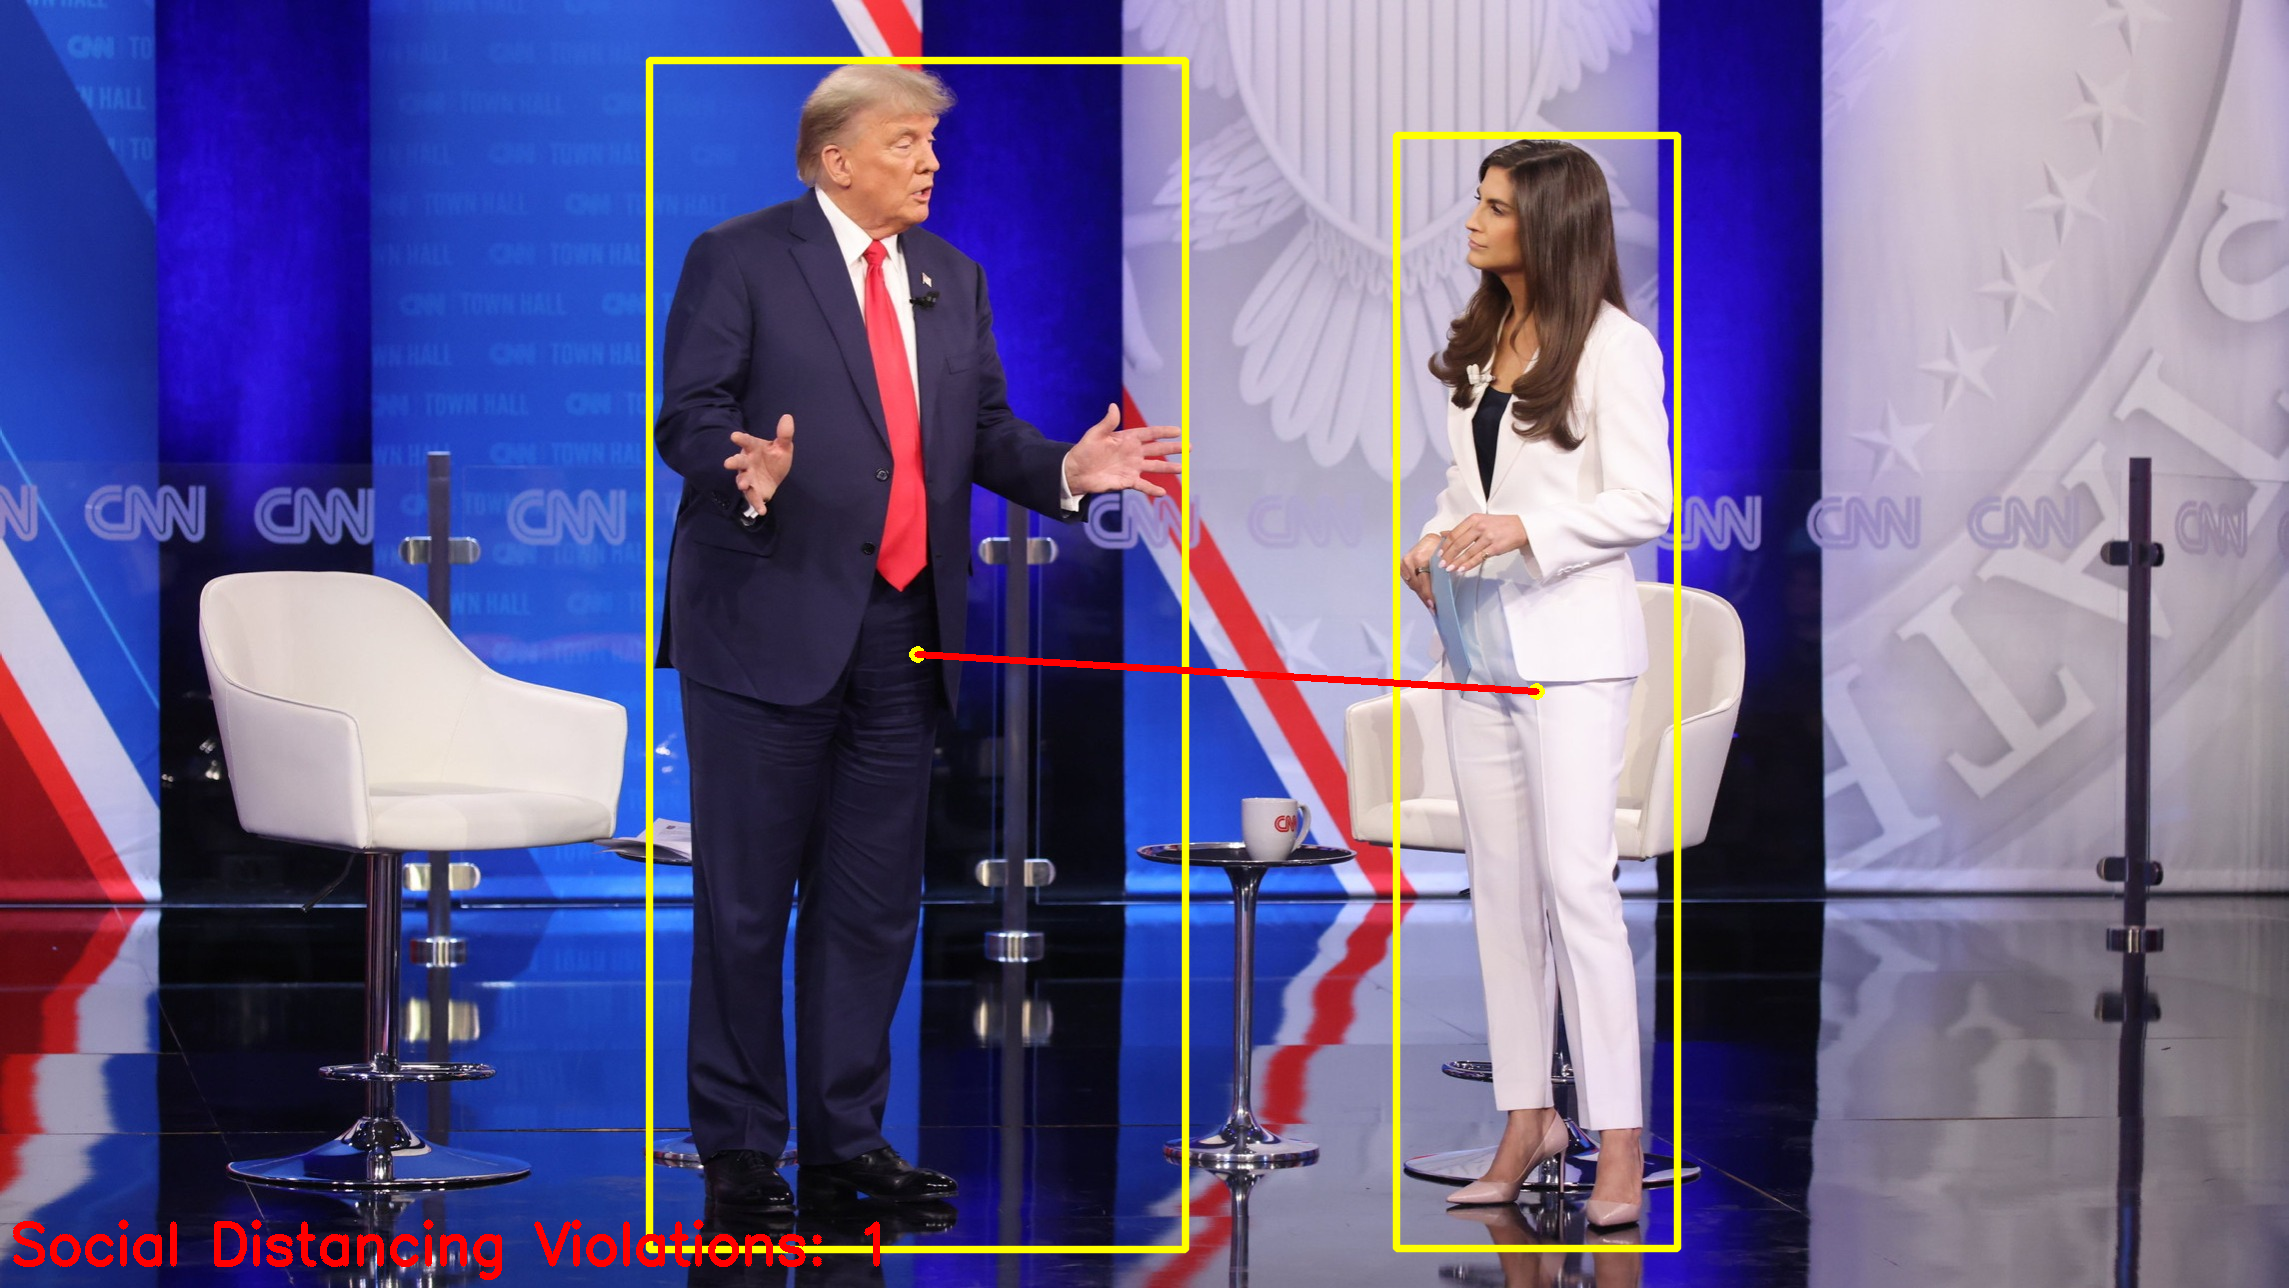

In [925]:
input_image = np.array(Image.open('t.jpg'))
detections = detect(input_image, det_compiled_model)
draw_results(detections, input_image)

Image.fromarray(input_image)

In [926]:
detect(input_image, det_compiled_model)

tensor([[6.52000e+02, 6.30000e+01, 1.16600e+03, 1.26000e+03, 8.93076e-01, 0.00000e+00],
        [1.40200e+03, 1.35000e+02, 1.67800e+03, 1.25000e+03, 8.82810e-01, 0.00000e+00]])